In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTModel, ViTConfig


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/new/tomato/train'
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize images
])

In [ ]:
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
num_classes = len(dataset.classes)
num_classes

10

In [ ]:

class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super(HybridModel, self).__init__()

        # Load a pre-trained ResNet50 as the CNN part
        self.cnn = resnet50(pretrained=True)
        self.cnn.fc = nn.Identity() # Remove the last fully connected layer

        # Configure and load a Vision Transformer
        config = ViTConfig(
            image_size=224, # Assuming input images are 224x224
            patch_size=16,
            num_classes=num_classes,
            hidden_size=768,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
        )
        self.vit = ViTModel(config)

        # Fully connected layer to combine CNN and ViT outputs
        self.fc = nn.Linear(2816, num_classes) # Adjust the input size to 2816

    def forward(self, x):
        # Pass the input through the CNN
        cnn_out = self.cnn(x)

        # Flatten the CNN output
        cnn_out = cnn_out.view(cnn_out.size(0), -1)

        # Pass the input through the ViT
        vit_out = self.vit(x).last_hidden_state[:, 0, :] # Take the [CLS] token's output

        # Concatenate the CNN and ViT outputs
        combined = torch.cat((cnn_out, vit_out), dim=1)

        # Pass the combined output through the fully connected layer
        out = self.fc(combined)

        return out

In [ ]:
from torchvision.models import resnet50


In [ ]:
model = HybridModel(num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 5 # Number of epochs for training
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")



Epoch 1, Loss: 0.5911993822258599
Epoch 2, Loss: 0.26062141722595356
Epoch 3, Loss: 0.19746980380044324
Epoch 4, Loss: 0.17096788624781858
Epoch 5, Loss: 0.13243920192614478


In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize images
])


In [ ]:
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/new/tomato/val', transform=val_transform)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
model.eval() # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        print(f"Predicted: {predicted}, Actual: {labels}")

Predicted: tensor([0, 6, 6, 5, 4, 3, 6, 5, 4, 0, 7, 9, 4, 9, 5, 2, 5, 4, 3, 1, 4, 5, 6, 0,
        9, 3, 4, 3, 4, 2, 3, 4]), Actual: tensor([0, 6, 6, 5, 4, 3, 6, 5, 4, 0, 7, 9, 4, 9, 5, 2, 5, 4, 3, 1, 4, 5, 6, 0,
        9, 3, 4, 3, 8, 2, 3, 8])
Predicted: tensor([9, 6, 7, 1, 4, 5, 9, 8, 4, 6, 1, 7, 8, 1, 7, 5, 8, 7, 9, 9, 8, 0, 0, 8,
        9, 5, 2, 4, 9, 9, 6, 5]), Actual: tensor([9, 6, 7, 1, 4, 5, 9, 8, 4, 1, 1, 7, 8, 1, 7, 6, 8, 7, 9, 9, 8, 0, 0, 8,
        9, 5, 2, 4, 9, 9, 6, 5])
Predicted: tensor([7, 7, 1, 5, 8, 0, 1, 5, 4, 0, 8, 3, 1, 1, 2, 9, 1, 5, 1, 8, 6, 9, 6, 3,
        8, 0, 1, 4, 3, 4, 4, 2]), Actual: tensor([7, 7, 1, 5, 8, 0, 1, 5, 8, 0, 8, 3, 1, 1, 2, 9, 1, 5, 1, 8, 6, 9, 6, 3,
        8, 0, 1, 4, 3, 4, 4, 2])
Predicted: tensor([3, 8, 4, 4, 4, 6, 7, 1, 5, 1, 0, 3, 3, 3, 7, 1, 2, 9, 9, 3, 4, 3, 6, 3,
        3, 0, 3, 1, 3, 7, 1, 9]), Actual: tensor([3, 8, 6, 4, 4, 6, 7, 1, 5, 1, 0, 2, 3, 3, 7, 1, 2, 9, 9, 3, 4, 3, 6, 3,
        3, 7, 3, 1, 3, 7, 1, 9])
Predicted: tenso

KeyboardInterrupt: 

In [ ]:
def calculate_accuracy(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


In [ ]:
calculate_accuracy(model, test_dataloader)

93.4

In [ ]:
torch.save(model, 'model.pth')

# Or, save only the state dictionary
torch.save(model.state_dict(), 'model_state_dict.pth')

print("Model saved successfully.")


Model saved successfully.


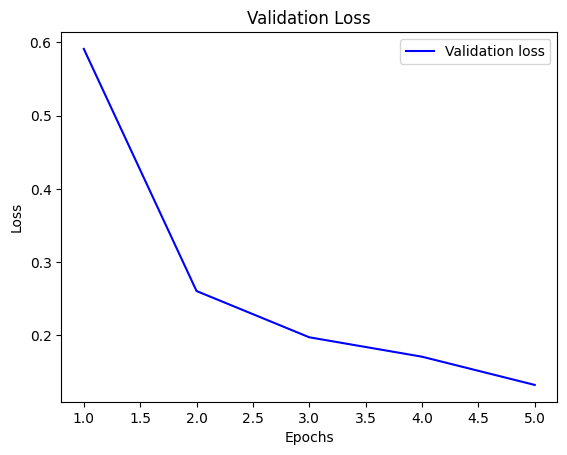

In [ ]:
import matplotlib.pyplot as plt

# Validation loss values
loss_values = [0.5911993822258599, 0.26062141722595356, 0.19746980380044324, 0.17096788624781858, 0.13243920192614478]

# Number of epochs
epochs = range(1, len(loss_values) + 1)

# Plotting the validation loss
plt.plot(epochs, loss_values, 'b-', label='Validation loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
